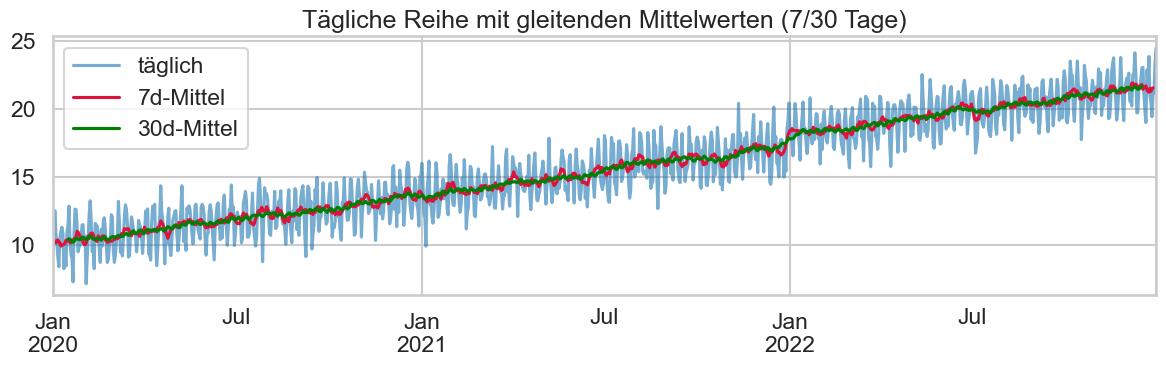

/var/folders/nw/k_k0_cbj7vl_npdmryvhl53c0000gn/T/ipykernel_24271/297039754.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts.resample("M").mean().plot(ax=ax[1], color="tab:orange")


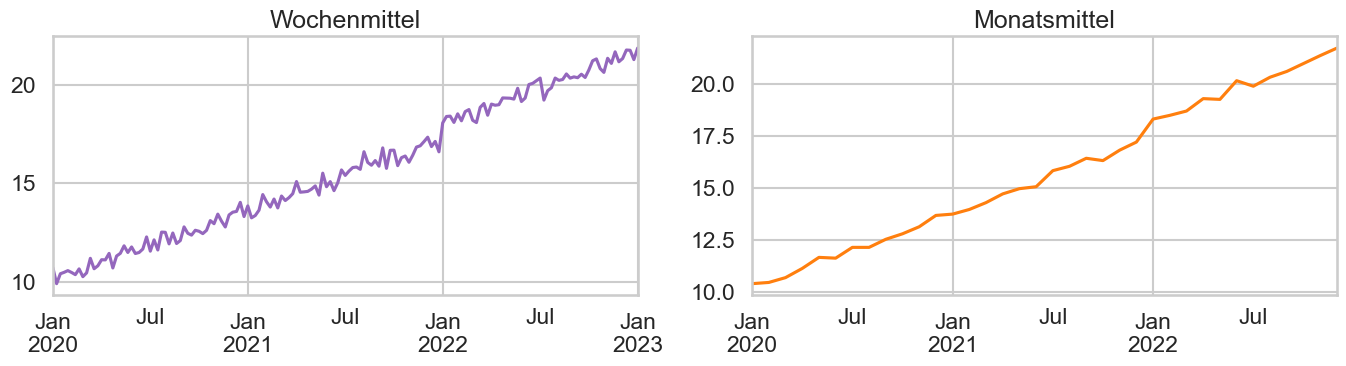

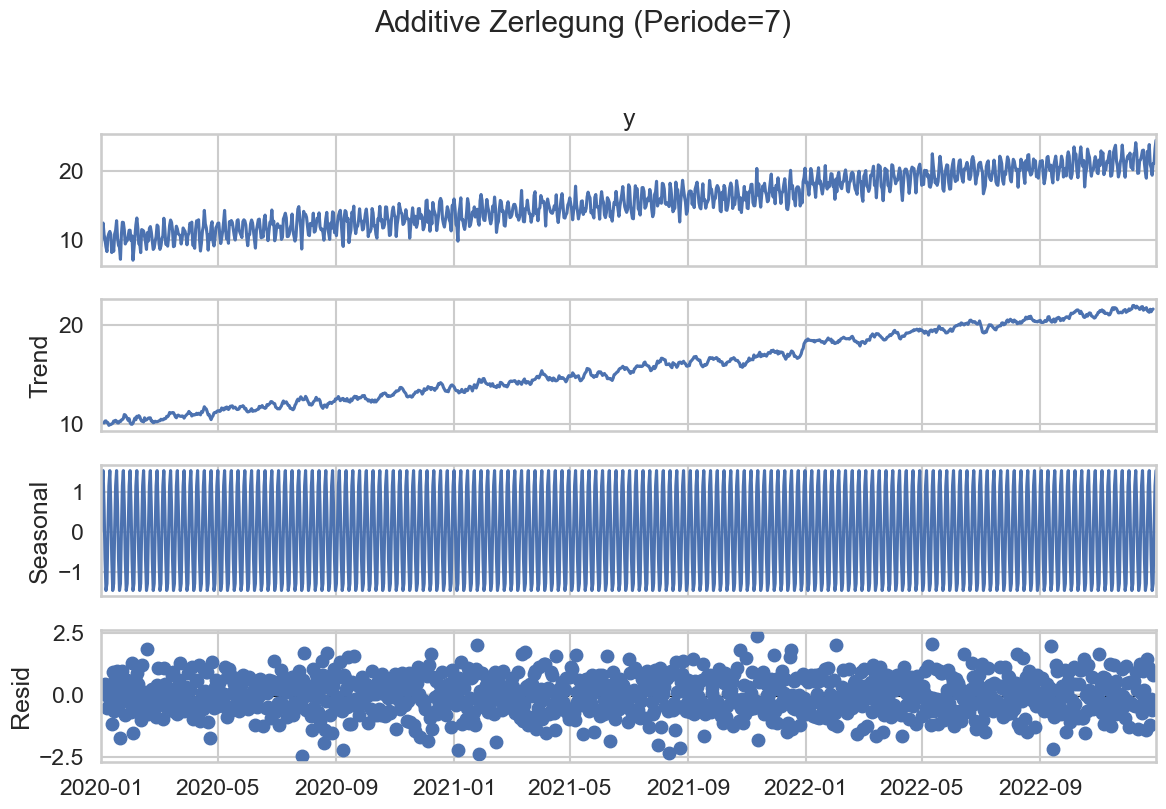

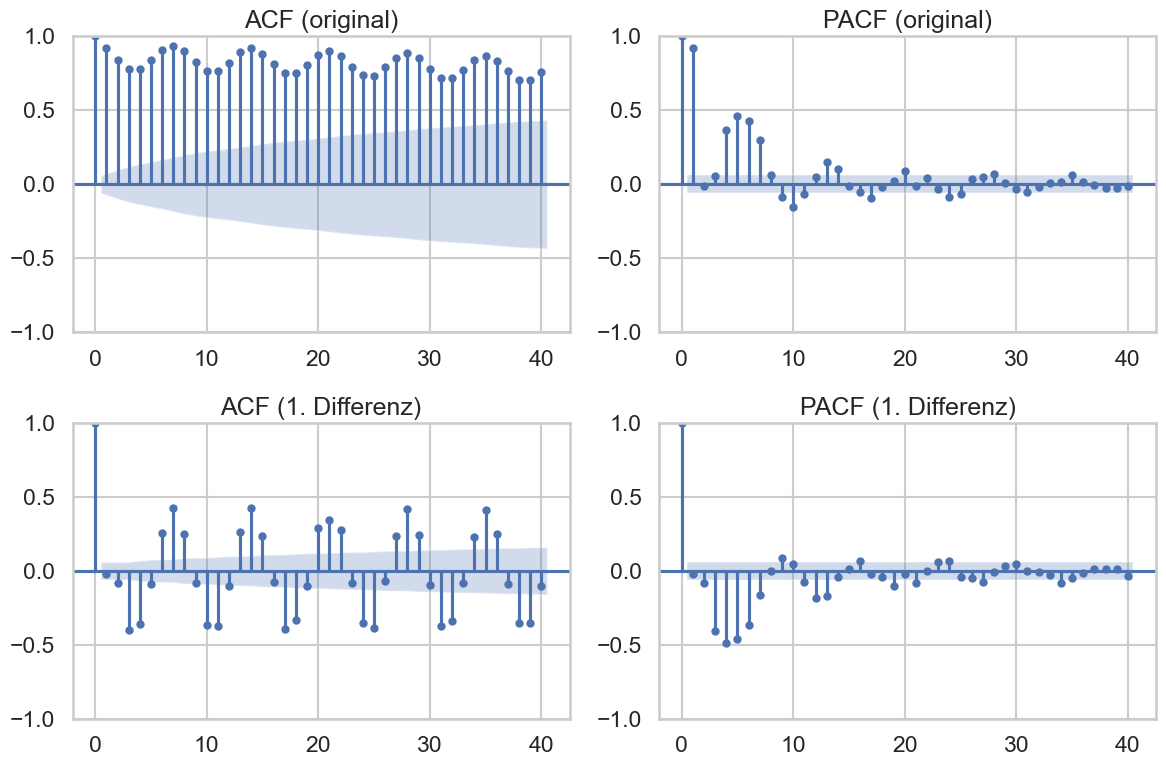

[INFO] Train-Länge: 915 | Test-Länge: 180 | Ende Train: 2022-07-03
            Naiv  MAE=1.448  RMSE=1.770  MAPE=6.78%
    SaisonalNaiv  MAE=1.436  RMSE=1.764  MAPE=6.72%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

    ARIMA(1,1,1)  MAE=1.421  RMSE=1.735  MAPE=6.66%
      SARIMA s=7  MAE=0.750  RMSE=0.917  MAPE=3.70%


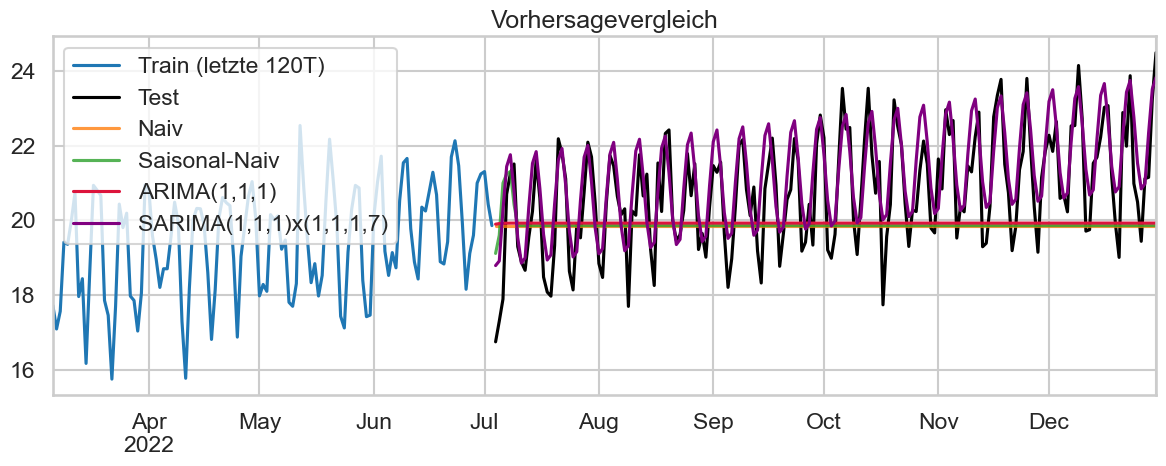

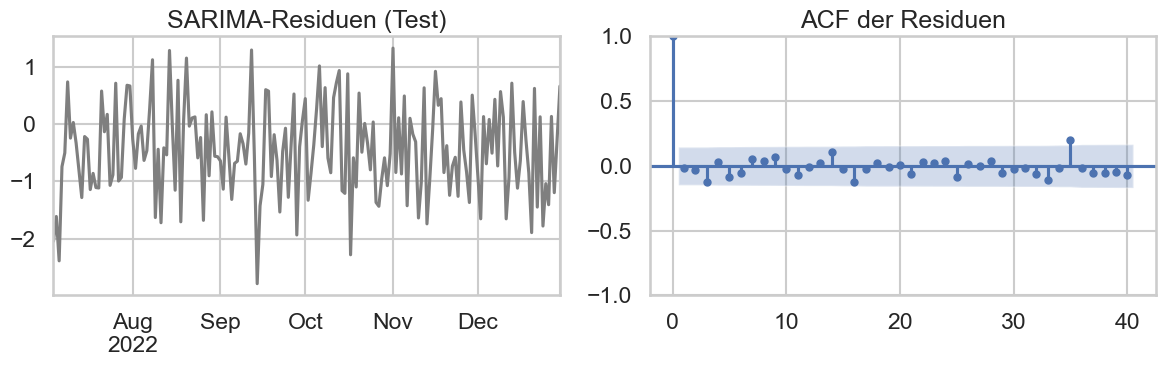


Ljung–Box-Test auf Residuen (H0: keine Autokorrelation):
      lb_stat  lb_pvalue
7    5.701955   0.574949
14  10.571528   0.719319
21  14.620726   0.841491

Fertig: Glätten/Resampling, Zerlegung, ACF/PACF, Differenzen, Baselines, ARIMA vs. SARIMA und Residuen-Checks.


In [1]:
"""
Vorlesung 4 – Zeitreihen (selbstständig lauffähig)
- Erzeugt eine tägliche synthetische Reihe mit Trend + wöchentlicher Saisonalität + Rauschen (+ kleinem Level-Shift)
- Zeigt Glätten (Moving Average), Resampling, Zerlegung (additiv)
- ACF/PACF vor/nach Differenzieren
- Zeitgerechter Train/Test-Split, Baselines (naiv, saisonal-naiv)
- ARIMA(1,1,1) vs. SARIMA(1,1,1)x(1,1,1,7)
- Residuen-ACF + Ljung–Box-Test
Benötigt: numpy, pandas, seaborn, matplotlib, statsmodels, scipy, scikit-learn (nur Metriken)
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

sns.set_theme(style="whitegrid", context="talk")
rng = np.random.default_rng(123)

# ------------------------------------------------------------
# 0) Synthetische tägliche Daten: Trend + Wochenmuster + Rauschen + Level-Shift
# ------------------------------------------------------------
n_days = 3 * 365  # ~3 Jahre
idx = pd.date_range("2020-01-01", periods=n_days, freq="D")

trend = 0.01 * np.arange(n_days)                      # sanfter Aufwärtstrend
weekly = 1.5 * np.sin(2*np.pi*np.arange(n_days)/7.0)  # wöchentliche Saisonalität
noise = rng.normal(0, 0.8, size=n_days)               # Rauschen

y = 10 + trend + weekly + noise
y[2*365:] += 0.7  # leichter Level-Shift nach ~2 Jahren

ts = pd.Series(y, index=idx, name="y")

# ------------------------------------------------------------
# 1) Rohreihe, gleitende Mittelwerte, Resampling
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ts.plot(ax=ax, color="tab:blue", alpha=0.6, label="täglich")
ts.rolling(7, center=True).mean().plot(ax=ax, color="crimson", label="7d-Mittel")
ts.rolling(30, center=True).mean().plot(ax=ax, color="green", label="30d-Mittel")
ax.set_title("Tägliche Reihe mit gleitenden Mittelwerten (7/30 Tage)")
ax.legend()
plt.tight_layout(); plt.show()

# Resampling: Wochen- und Monatsmittel
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ts.resample("W").mean().plot(ax=ax[0], color="tab:purple")
ax[0].set_title("Wochenmittel")
ts.resample("M").mean().plot(ax=ax[1], color="tab:orange")
ax[1].set_title("Monatsmittel")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 2) Additive Zerlegung (period=7): Trend + Saison + Rest
# ------------------------------------------------------------
decomp = seasonal_decompose(ts, model="additive", period=7)  # wöchentliche Periode
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Additive Zerlegung (Periode=7)", y=1.02)
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 3) ACF/PACF: original vs. 1. Differenz
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(ts, lags=40, ax=axes[0,0])
axes[0,0].set_title("ACF (original)")
plot_pacf(ts, lags=40, ax=axes[0,1], method="ywm")
axes[0,1].set_title("PACF (original)")

diff1 = ts.diff().dropna()  # erste Differenz
plot_acf(diff1, lags=40, ax=axes[1,0])
axes[1,0].set_title("ACF (1. Differenz)")
plot_pacf(diff1, lags=40, ax=axes[1,1], method="ywm")
axes[1,1].set_title("PACF (1. Differenz)")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 4) Zeitgerechter Split: letzte 6 Monate als Test
# ------------------------------------------------------------
split_date = ts.index.max() - pd.Timedelta(days=180)
y_train = ts.loc[:split_date]
y_test  = ts.loc[split_date+pd.Timedelta(days=1):]

print(f"[INFO] Train-Länge: {len(y_train)} | Test-Länge: {len(y_test)} | Ende Train: {y_train.index[-1].date()}")

# ------------------------------------------------------------
# 5) Baselines: naiv (t-1) und saisonal-naiv (t-7)
# ------------------------------------------------------------
def naive_forecast(series, horizon):
    last = series.iloc[-1]
    return pd.Series([last]*horizon, index=y_test.index)

def seasonal_naive_forecast(series, horizon, s=7):
    history = series.copy()
    preds = []
    for t in y_test.index:
        lag_idx = t - pd.Timedelta(days=s)
        preds.append(history.loc[lag_idx] if lag_idx in history.index else history.iloc[-1])
    return pd.Series(preds, index=y_test.index)

y_pred_naive = naive_forecast(y_train, len(y_test))
y_pred_seasonal = seasonal_naive_forecast(y_train, len(y_test), s=7)

def mape(y_true, y_pred):
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(eps, np.abs(y_true))))) * 100

def report_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mp = mape(y_true, y_pred)
    print(f"{name:>16s}  MAE={mae:.3f}  RMSE={rmse:.3f}  MAPE={mp:.2f}%")

report_metrics("Naiv", y_test, y_pred_naive)
report_metrics("SaisonalNaiv", y_test, y_pred_seasonal)

# ------------------------------------------------------------
# 6) ARIMA vs. SARIMA (saisonale Periode 7)
# ------------------------------------------------------------
arima_111 = ARIMA(y_train, order=(1,1,1)).fit()
sarima = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,7),
                 enforce_stationarity=False, enforce_invertibility=False).fit()

arima_fc = arima_111.get_forecast(steps=len(y_test)).predicted_mean
sarima_fc = sarima.get_forecast(steps=len(y_test)).predicted_mean
arima_fc.index = y_test.index
sarima_fc.index = y_test.index

report_metrics("ARIMA(1,1,1)", y_test, arima_fc)
report_metrics("SARIMA s=7",   y_test, sarima_fc)

plt.figure(figsize=(12, 5))
y_train.tail(120).plot(label="Train (letzte 120T)", color="tab:blue")
y_test.plot(label="Test", color="black")
y_pred_naive.plot(label="Naiv", color="tab:orange", alpha=0.8)
y_pred_seasonal.plot(label="Saisonal-Naiv", color="tab:green", alpha=0.8)
arima_fc.plot(label="ARIMA(1,1,1)", color="crimson")
sarima_fc.plot(label="SARIMA(1,1,1)x(1,1,1,7)", color="purple")
plt.title("Vorhersagevergleich")
plt.legend()
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 7) Residuen-Diagnostik: ACF + Ljung–Box
# ------------------------------------------------------------
resid_sarima = (y_test - sarima_fc)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
resid_sarima.plot(ax=axes[0], color="tab:gray")
axes[0].set_title("SARIMA-Residuen (Test)")
plot_acf(resid_sarima.dropna(), lags=40, ax=axes[1])
axes[1].set_title("ACF der Residuen")
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(resid_sarima.dropna(), lags=[7,14,21], return_df=True)
print("\nLjung–Box-Test auf Residuen (H0: keine Autokorrelation):")
print(lb)

print("\nFertig: Glätten/Resampling, Zerlegung, ACF/PACF, Differenzen, Baselines, ARIMA vs. SARIMA und Residuen-Checks.")
